In [1]:
%load_ext autoreload
%autoreload 2

In [188]:
import sys

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "../..")

# Install transformers / huggingface.
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install transformers
# !{sys.executable} -m pip install mkl
# !{sys.executable} -m pip install vision

# Or otherwise install trulens.
# !{sys.executable} -m pip install git+https://github.com/truera/trulens.git
# ! {sys.executable} -m pip uninstall trulens -y

from IPython.display import display
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from types import SimpleNamespace
import base64
from tqdm.auto import tqdm
import re
from typing import List, Tuple
import functools

# Twitter Sentiment Model

[Huggingface](https://huggingface.co/models) offers a variety of pre-trained NLP models to explore. We exemplify in this notebook a [transformer-based twitter sentiment classification model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). Before getting started, familiarize yourself with the general Truera API as demonstrated in the [intro notebook using pytorch](intro_demo_pytorch.ipynb).

In [164]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer


# Wrap all of the necessary components.
class TwitterSentiment:
    #device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    MODEL = f"distilbert-base-uncased-finetuned-sst-2-english"
    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    embeddings = model.distilbert.embeddings.word_embeddings.weight.detach(
    ).cpu().numpy()
    embeddings_layer = 'distilbert_embeddings_word_embeddings'

    max_length = 256

    # MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
    #embeddings = model.roberta.embeddings.word_embeddings.weight.detach().cpu().numpy()
    #embeddings_layer = 'roberta_embeddings_word_embeddings'

    def tokenize(texts: List[str]):
        return TwitterSentiment.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=TwitterSentiment.max_length,
            return_tensors='pt'
        ).to(TwitterSentiment.device)

    def token_str(token_id: int):
        tok = task.tokenizer.decode(token_id)
        if tok.startswith("##"
                         ):  # token starts with "##" to denote a word postfix
            return tok[2:]
        else:
            return " " + tok  # if not a postfix, add space better indicate a complete word separation

    id_of_token = tokenizer.get_vocab()
    token_of_id = {v: k for k, v in id_of_token.items()}

    labels = [
        'negative',
        #'neutral', # for roberta
        'positive'
    ]

    NEGATIVE = labels.index('negative')
    #NEUTRAL = labels.index('neutral') # for roberta
    POSITIVE = labels.index('positive')

task = TwitterSentiment


This model quantifies tweets (or really any text you give it) according to its sentiment: positive, negative, or neutral. Lets try it out on some examples.

In [165]:
sentences = ["I'm so happy!", "I'm so sad!", "I cannot tell whether I should be happy or sad!", "meh"]

# Input sentences need to be tokenized first.

inputs = task.tokenize(sentences)

# The tokenizer gives us vocabulary indexes for each input token (in this case,
# words and some word parts like the "'m" part of "I'm" are tokens).

print(inputs)

# Decode helps inspecting the tokenization produced:

print(task.tokenizer.batch_decode(torch.flatten(inputs['input_ids'])))
# Normally decode would give us a single string for each sentence but we would
# not be able to see some of the non-word tokens there. Flattening first gives
# us a string for each input_id.

{'input_ids': tensor([[ 101, 1045, 1005, 1049, 2061, 3407,  999,  102,    0,    0,    0,    0,
            0],
        [ 101, 1045, 1005, 1049, 2061, 6517,  999,  102,    0,    0,    0,    0,
            0],
        [ 101, 1045, 3685, 2425, 3251, 1045, 2323, 2022, 3407, 2030, 6517,  999,
          102],
        [ 101, 2033, 2232,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}
['[CLS]', 'i', "'", 'm', 'so', 'happy', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'i', "'", 'm', 'so', 'sad', '!', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[CLS]', 'i', 'cannot', 'tell', 'whether', 'i', 'should', 'be', 'happy', 'or', 'sad', '!', '[SEP]', '[CLS]', 'me', '##h', '[SEP]', '[PAD]', '[PAD]', '[

Evaluating huggingface models is straight-forward if we use the structure produced by the tokenizer.

In [66]:
outputs = task.model(**inputs)

print(outputs)

# From logits we can extract the most likely class for each sentence and its readable label.

predictions = [task.labels[i] for i in outputs.logits.argmax(axis=1)]

for sentence, logits, prediction in zip(sentences, outputs.logits, predictions):
    print(logits.to('cpu').detach().numpy(), prediction, sentence)

SequenceClassifierOutput(loss=None, logits=tensor([[-4.3097,  4.6567],
        [ 4.1629, -3.3825],
        [ 3.4624, -2.8729],
        [-1.8104,  2.0322]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
[-4.309732  4.656725] positive I'm so happy!
[ 4.162882  -3.3825326] negative I'm so sad!
[ 3.4624143 -2.872939 ] negative I cannot tell whether I should be happy or sad!
[-1.810366   2.0321987] positive meh


In [166]:
def evaluate_to_probits(texts: List[str]) -> np.ndarray:
    """
    Evaluate a collection of `texts` into their probits scores.
    """

    inputs = task.tokenize(texts)

    logits = task.model(**inputs).logits

    probits = torch.nn.functional.softmax(logits, dim=1)

    return probits

evaluate_to_probits(["This is great.", "This is not great."])

tensor([[1.2098e-04, 9.9988e-01],
        [9.9978e-01, 2.2359e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Model Wrapper

As in the prior notebooks, we need to wrap the pytorch model with the appropriate Trulens functionality. Here we specify the maximum input size (in terms of tokens) each tweet may have.

In [167]:
from trulens.nn.models import get_model_wrapper
from trulens.nn.quantities import ClassQoI
from trulens.nn.attribution import IntegratedGradients
from trulens.nn.attribution import Cut, OutputCut
from trulens.utils.typing import ModelInputs

task.wrapper = get_model_wrapper(task.model, device=task.device)

INFO: Detected pytorch backend for <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>.
INFO: Using backend Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


# Attributions

In [237]:
common_attributor_arguments = dict(
    model=task.wrapper,
    resolution=128,
    rebatch_size=32,
    doi_cut=Cut(task.embeddings_layer),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

infl = IntegratedGradients(
    **common_attributor_arguments
)

A listing as above is not very readable so Trulens comes with some utilities to present token influences a bit more concisely. First we need to set up a few parameters to make use of it:

In [238]:
from trulens.visualizations import NLP

V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=task.token_str,
    tokenize=lambda sentences: ModelInputs(kwargs=task.tokenize(sentences,)).
    map(lambda t: t.to(task.device)),
    # huggingface models can take as input the keyword args as per produced by their tokenizers.
    input_accessor=lambda x: x.kwargs['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary
    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary
    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

print("QOI = POSITIVE")
display(V.tokens(sentences, infl))

QOI = POSITIVE


# Baselines

We see in the above results that special tokens such as the sentence end **&lt;/s&gt;** contributes are found to contribute a lot to the model outputs. While this may be useful in some contexts, we are more interested in the contributions of the actual words in these sentences. To focus on the words more, we need to adjust the **baseline** used in the integrated gradients computation. By default in the instantiation so far, the baseline for each token is a zero vector of the same shape as its embedding. By making the basaeline be identicaly to the explained instances on special tokens, we can rid their impact from our measurement. Trulens provides a utility for this purpose in terms of `token_baseline` which constructs for you the methods to compute the appropriate baseline. 

In [170]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.sep_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

We can now inspect the baselines on some example sentences. The first method returned by `token_baseline` gives us token ids to inspect while the second gives us the embeddings of the baseline which we will pass to the attributions method.

In [171]:
print("originals=", task.tokenizer.batch_decode(inputs['input_ids']))

baseline_word_ids = inputs_baseline_ids(model_inputs=ModelInputs(args=[], kwargs=inputs))

print("baselines=", task.tokenizer.batch_decode(baseline_word_ids))

originals= ["[CLS] i'm so happy! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]", "[CLS] i'm so sad! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]", '[CLS] i cannot tell whether i should be happy or sad! [SEP]', '[CLS] meh [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']
baselines= ['[CLS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [SEP]', '[CLS] [PAD] [PAD] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]']


In [239]:
infl_positive_baseline = IntegratedGradients(
    baseline = inputs_baseline_embeddings,
    **common_attributor_arguments
)

print("QOI = POSITIVE WITH BASELINE")
display(V.tokens(sentences, infl_positive_baseline))

QOI = POSITIVE WITH BASELINE


# Stability

In [240]:
from datasets import load_dataset

rotten_train = load_dataset("rotten_tomatoes", split="train")
rotten_test = load_dataset("rotten_tomatoes", split="test")
rotten_texts = rotten_train['text'] + rotten_test['text']

In [241]:
def word_pattern(word):
    """
    Create a pattern that matches the given `word` as long as it is not
    immediately next to an alpha-numeric character.
    """
    return "(?<!\w)" + re.escape(word) + "(?!\w)"

def swap(thing1: str, thing2: str):
    """
    Create a method to swap occurances of `thing1` and `thing2`.
    """

    pat_swapper = re.compile(r":swapper:")
    pat1 = re.compile(word_pattern(thing1), re.IGNORECASE)
    pat2 = re.compile(word_pattern(thing2), re.IGNORECASE)

    def f(sentence: str):        
        """
        Swap instances of thing1 and thing2 in sentence.
        """
        
        temp1 = pat1.sub(":swapper:", sentence)
        temp2 = pat2.sub(thing1, temp1)
        temp3 = pat_swapper.sub(thing2, temp2)
        return temp3

    return f

def contains(s: str, pat: re.Pattern):
    """
    Determine whether the given string `s` satisfies regular expression `pat`.
    """
    return pat.search(s) is not None

In [242]:
token_pairs = [
    ("good", "great"),
    ("great", "amazing"),
    ("good", "amazing"),
]

def get_sentence_pairs(token_pairs: List[Tuple[str, str]],
                       texts: List[str]) -> List[Tuple[str, str]]:
    """
    Create sentence pairs from examples in `texts` that swap words from the
    pairs list `token_pairs`.
    """

    patterns = [
        re.compile(
            "|".join([word_pattern(tok) for tok in pair]), re.IGNORECASE
        ) for pair in token_pairs
    ]
    swappers = [swap(*pair) for pair in token_pairs]

    sentence_pairs = [
        (sentence, swap(sentence))
        for pattern, swap in
        tqdm(zip(patterns, swappers), desc="finding swap pairs", unit="pair")
        for sentence in texts
        if contains(sentence, pattern)
    ]

    print(f"found {len(sentence_pairs)} pair(s)")

    return sentence_pairs


sentence_pairs_quality = get_sentence_pairs(token_pairs, rotten_texts)

finding swap pairs: 0pair [00:00, ?pair/s]

found 1002 pair(s)


In [243]:
def compute_pair_disparities(
    sentence_pairs: List[Tuple[str, str]]
) -> List[Tuple[Tuple[str, str], float]]:
    """
    Given a collection of `sentence_pairs`, produce a list of tuples containing
    the pairs as the first element and the disparity in model scores as the second.
    """

    diffs = []

    for pair in tqdm(sentence_pairs,
                     desc="evaluating sentence pair score differences"):
        a_probits, b_probits = evaluate_to_probits(list(pair))

        diffs.append(
            torch.nn.functional.cross_entropy(
                torch.unsqueeze(a_probits, dim=0),
                torch.unsqueeze(b_probits, dim=0)
            ).detach().cpu().numpy()
        )

    diffs = np.array(diffs)
    diffs_pairs = list(
        reversed(sorted(zip(sentence_pairs, diffs), key=lambda pair: pair[1]))
    )

    return diffs_pairs

diffs_pairs_quality = compute_pair_disparities(sentence_pairs_quality)

evaluating sentence pair score differences:   0%|          | 0/1002 [00:00<?, ?it/s]

In [244]:
def show_biggest_disparities(
    diffs: List[Tuple[Tuple[str, str], float]],
    attributor=infl_positive_baseline,
    n=3
) -> None:
    """
    Display the top disparate pairs along with their attributions.
    """

    display(
        V.tokens_stability(
            texts1=[p[0][0] for p in diffs][0:n],
            texts2=[p[0][1] for p in diffs][0:n],
            attributor=attributor
        )
    )


show_biggest_disparities(diffs_pairs_quality)

# Fairness

In [245]:
gender_pairs = [
    ('he', 'she'),
    ('guy', 'gal'),
    ('himself', 'herself'),
    ('boy', 'girl'),
    ('husband', 'wife'),
    ('man', 'woman'),
    ('men', 'women'),
    ('brother', 'sister'),
    ('uncle', 'aunt'),
    ('nephew', 'niece'),
    ('dad', 'mom'),
    ('father', 'mother'),
    ('son', 'daughter'),
    ('actor', 'actress'),
    ('male', 'female'),
    ('hero', 'heroine'),
]

sentence_pairs_gender = get_sentence_pairs(gender_pairs, rotten_texts)
diffs_pairs_gender = compute_pair_disparities(sentence_pairs_gender)

finding swap pairs: 0pair [00:00, ?pair/s]

found 1004 pair(s)


evaluating sentence pair score differences:   0%|          | 0/1004 [00:00<?, ?it/s]

In [246]:
show_biggest_disparities(diffs_pairs_gender)

In [250]:
embeddings = task.embeddings

# A vector approximating the difference between embeddings of pairs of words
# of the opposite gender. This one is for the token embedding used in
# distilbert.
gender_vector = np.frombuffer(
    base64.b85decode(
        b'?4-;r+n_BbxT&BWWUIlV^Qc9YM<?$ffFvBOyeVWPZ6QZ1ttD(IWT3Vs@g>z1(IHALq#<!8`6&IFovN59FQQ<rjVfRxf2awiYAAOf0xHHLzn)JeL8GLalpxcndmiqk3oS&V=c3uGKP<ea=_dCgN-Vq~^C<SDBB=f;{-m#?lBazp6`Fi20ii4{HmQFaeJNI`eJG!zN2p7nT&MsSPpc;*^d-=!XDFVgZ7N3{HKO`0uqm#msif;Ew5=Wq#ib{lJ)>zVdn~jjwWg4$E-Hm9mL8ELf+nV@>7XN}EFh#J6Du&8d89uqq^KIJJfWAH<s(?A83iFILnMlrgei)r<*S^fJgHDAWT^b8{i%wqmaLPhbS9T6Jt#99Sf6L8+bydo;3dAJS}Uz4E1CW%<)@0Q!Ypv2O(|R<c%D?4xR(l{UL)hBP^^)syPV#omZOCyB&3O+Iv%o~8KW|tw5a_oU?h^MQ!4KuK_zc2qAUp_g(MRpzbQy4vZ$V-e<o?1A1Fqg-lZKX51h559ip|Y3@9lngeeCdV4_MV1tujcN-QR*NT-IaRil6?RICoHU?Y?#zN8MQpeo*^uBGuJ$tk-V*C>ytF{UOeM4I9z{VUa<Vx*-d-l$9`fGFf76r}JNuPLCYkTBb<^`&<w5-3!r4Wiwe2&9!9nI?EFcBnfjS1ipX@gcS+XD6R2W3AF1h>!iL@|kC$dla6YHl}MM<0kVa@~U*KA0pVH3?n6;I4Dsj{2DZ*bRJnH^CRFT$f!e}dniDvR;=tH3Mn0=KqeCw)1Lk)mZ)|kEUBrWAE-g9fhH>_i>J6EXBbkVJ|R9RW2H-=R-}(7FDB6^EvphMpez}nRGA2_{iNV0kf_8hG_1QR;-b?fwIDDpnI}W4-5<av4k0q42p)f_%Ay~t-K6*-@+Mjz%$YHy51(}(H7Uv>(<l=m@*IUHzoEq}BB-CJ^(USw-Yae=oTara=C19iiYMJ3?yV>$*qY=iC!+l-R;E;>I4FCe5iVFIf2tZC5UZpoNG!mnxS~QM38iYMm?*WNN1_!Zh^a27Eu`Qoc$}IfR+ikN7@WSNXQ}EcY!wqH2PuOl#HIx#l_0O7ogf&f@u_Slmm`>_AgeQ^RwvCWk}20BY9RBYb|sFgpeAH0Dx#e#tt9TASt-Dq@1$NOs3duoK`EM`FQsOske;`wT_Z0g0w<>+xh5K%eJIJG%cHs?)}7U(Vx_Yrcpk?fF(C#ZaHY4W)TXW`zn~3}NvZsnOQu36Q6W#L)T+R%yeKOyr=sMY+ou^QsHsz@^&6EdH6?hZOqr#q&8vec0VOpo7b`0ylcE<TLM8XAv7>h-WRQC!;i)z*1gXcS@g$NXP%J#EOdu8^39HJf-!4$5t1F|X>nB1bOs2G`_@1C8;w3n$h$<i`f+X;tZX^b#;Ucys8?I0(!zlPFE1h{F1FV`R&#Ig!^d}%BvmpE}lBB68#i@S|a3H`YHy+|3qoeSwl&35tv!2JIffi^f_$lxpN~Hd%My0>0I32|%;S;zZ38EJ*&ZM^~8z+q-g_sARQK)mI6e2np%BPPeTP$EE%&YOJg(wxF_94wE;wph611IgKq9+HaTdc1oA14&4ysA2+%p*K3yQG9HBPA3nuBm+}Bc<mgCL^*Z>ztA#$1O7^A1jL_&?9yoLLzG;4W}ldVyJc}@u_hmODydxda9wBL7j9dl?n!@W-8FCn5dm7l`5;HN2rgX&7LBtm8K*teWQw>D=p^^x~S!>GaR6#Mkv3kktndAR2qe)DyAc)iKy+Q&ZhH}K&En`@+qt+lOfouwj+$EbEZh08mM%hgeI${1Sv!*_$5}TS09xr!ljccx+a^awVhe0JfIpJSSmoK&7Kw@hbW;WB_D1h{;R}`OQ|d^%d6>`KqUt#-K4;xLadW0q^d!nF(UV!=_;$CJ1X3%@2E4Yk*i)Mz>y9k<fnnC5Gh|R<|O+jB#_&s2B9h)'
    ),
    dtype='float16'
)

def normalize(v):
    return v / np.linalg.norm(v, ord=2)

def normalize_many(v):
    """
    Normalize an array of vectors.
    """
    return v / np.linalg.norm(v, axis=1, ord=2)[:, np.newaxis]


all_embs_norm = normalize_many(embeddings)
baseline_penalties = np.abs(np.dot(all_embs_norm, gender_vector))

direction_vector: np.ndarray = gender_vector

def embedding_opposite_id(emb: np.ndarray) -> Tuple[int, float]:
    emb = normalize(emb)
    scores = np.abs(
        np.dot(
            normalize_many(
                emb - all_embs_norm + 0.000000001
            ), direction_vector
        )
    ) - 0.55 * baseline_penalties

    best = np.argmax(scores)

    return best, scores[best]

def embedding_opposite(emb: np.ndarray) -> np.ndarray:
    best_id, best_score = embedding_opposite_id(emb)

    if best_score > 0.25:
        return embeddings[best_id]
    else:
        return emb

def embedding_neutralize(emb: np.ndarray) -> np.ndarray:
    return emb - np.dot(emb, direction_vector) * direction_vector
    

@functools.lru_cache(maxsize=len(embeddings))
def token_id_opposite(token_id: int):
    """
    Try to find the opposite of `token_id` according to the direction of
    `direction_vector`. If a good candidate is not found, returns the given
    `token_id` instead.
    """
    best_id, best_score = embedding_opposite_id(all_embs_norm[token_id])

    if best_score > 0.20:
        return best_id
    else:
        return token_id


def swap_token(token: str) -> str:
    a_id = task.id_of_token[token]
    b_id = token_id_opposite(a_id)
    return task.token_of_id[b_id]

In [262]:
emb = embeddings[task.id_of_token['nurse']]

gender_mag = np.dot(emb, direction_vector)

neutral = emb - gender_mag * direction_vector

neutral_gender_mag = np.dot(neutral, direction_vector)

In [263]:
print(gender_mag)
print(neutral_gender_mag)

-0.34954697
6.6168606e-05


In [257]:
for (s1, _), _ in diffs_pairs_gender[0:10]:
    print("original sentence:", s1)
    toks = task.tokenize([s1])['input_ids'][0].detach().cpu().numpy()
    toks_opposites = [token_id_opposite(t) for t in toks]
    print("swapped sentence:", task.tokenizer.decode(toks_opposites))
    print()

original sentence: johnson has , in his first film , set himself a task he is not nearly up to .
swapped sentence: [CLS] johnson has, in her first film, set herself a task she is not nearly up to. [SEP]

original sentence: johnson has , in his first film , set himself a task he is not nearly up to .
swapped sentence: [CLS] johnson has, in her first film, set herself a task she is not nearly up to. [SEP]

original sentence: a well-made but emotionally scattered film whose hero gives his heart only to the dog .
swapped sentence: [CLS] a well - made but son scattered film whose heroine gives her heart only to the dog. [SEP]

original sentence: asia authors herself as anna battista , an italian superstar and aspiring directress who just happens to be her own worst enemy .
swapped sentence: [CLS] asia authors himself as anna son, an italian superstar and aspiring direct king who just happens to be his own worst enemy. [SEP]

original sentence: [fessenden] is much more into ambiguity and cre

In [236]:
def baseline_swap(z: torch.Tensor) -> torch.Tensor:
    if isinstance(z, torch.Tensor):
        z = z.detach().cpu().numpy()

    return torch.tensor(
        [[embedding_opposite(emb) for emb in instance] for instance in z]
    ).to(task.device)

infl_swap_gender = IntegratedGradients(
    baseline=baseline_swap,
    **common_attributor_arguments
)

show_biggest_disparities(diffs_pairs_gender, attributor=infl_positive_baseline)
show_biggest_disparities(diffs_pairs_gender, attributor=infl_swap_gender)

In [249]:
def baseline_neutralize(z: torch.Tensor) -> torch.Tensor:
    if isinstance(z, torch.Tensor):
        z = z.detach().cpu().numpy()

    return torch.tensor(
        [[embedding_neutralize(emb) for emb in instance] for instance in z]
    ).to(task.device)
    
infl_neutralize_gender = IntegratedGradients(
    baseline=baseline_neutralize,
    **common_attributor_arguments
)

show_biggest_disparities(diffs_pairs_gender, attributor=infl_positive_baseline)
show_biggest_disparities(diffs_pairs_gender, attributor=infl_neutralize_gender)

# Drift

In [ ]:
from datasets import load_dataset

imdb_train = load_dataset("imdb", "plain_text", split="train")
imdb_test = load_dataset("imdb", "plain_text", split="test")
imdb_texts = imdb_train['text'] + imdb_test['text']

In [100]:
def tokenize(portion):
    return task.tokenizer.batch_encode_plus(
        portion,
        add_special_tokens=True,
        return_attention_mask=False,
        max_length=512,
        truncation=True
    )['input_ids']

import os
os.environ['TOKENIZERS_PARALLELISM'] = '0'

import multiprocessing as mp
p = mp.Pool(24)

def toks_of_texts(texts):
    toks = p.map(tokenize, [texts[1000*i: 1000*(i+1)] for i in range(len(texts)//1000)])
    all = np.array([i for tok in toks for t in tok for i in t ])

    return all

def dists_of_texts(texts):
    all = toks_of_texts(texts)   

    counts = np.zeros(task.tokenizer.vocab_size)
    total = len(all)
    for i in all:
        counts[i] += 1

    dist = counts / total

    return counts, dist

def tops_of_texts(texts, n = 10):
    counts, dist = dists_of_texts(texts)

    return tops_of_dists(counts, dist, n=n)

def tops_of_dists(c, d, n=10):
    sortindex = np.argsort(d)
    top = []

    for idx in sortindex[0:n]:
        top.append((idx, c[idx], d[idx], task.tokenizer.decode(idx)))

    crest_pos = 0
    crest_neg = 0
    drest_pos = 0
    drest_neg = 0

    for idx in sortindex[n:-n]:
        if c[idx] >= 0:
            crest_pos += c[idx]
            drest_pos += d[idx]
        else:
            crest_neg += c[idx]
            drest_neg += d[idx]

    top.append((-1, crest_neg, drest_neg, "*"))
    top.append((-1, crest_pos, drest_pos, "*"))

    for idx in sortindex[-n:]:
        top.append((idx, c[idx], d[idx], task.tokenizer.decode(idx)))

    return top

In [20]:
c1, d1 = dists_of_texts(imdb_train['text'])
c2, d2 = dists_of_texts(rotten_train['text'])
top = tops_of_dists(c1 - c2, d1 - d2, n = 20)
sum([t[2] for t in top])

-4.6058643010660205e-14

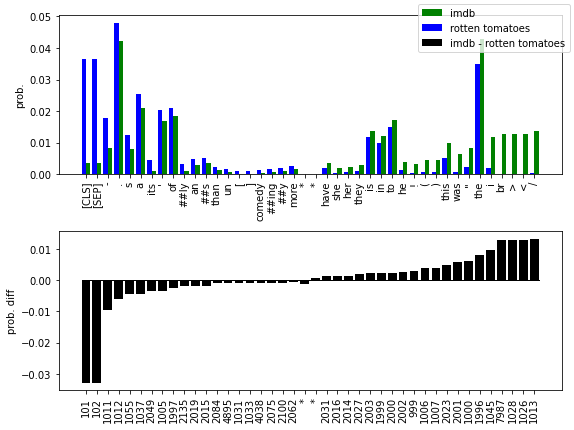

In [21]:
from matplotlib import transforms as trans

def plotdist(top, l1, l2):
    fig, ax = plt.subplots(2,1, figsize=(8,6))

    # ax[0].grid()
    ax[1].bar(x=range(len(top)), width=0.8, height=[t[2] for t in top], alpha=1.0, color="black", label=f"{l1} - {l2}")
    ax[0].bar(x=np.arange(len(top)) + 0.2, width=0.4, height=[d1[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="green", label=l1)    
    ax[0].bar(x=np.arange(len(top)) - 0.2, width=0.4, height=[d2[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="blue", label=l2)
    ax[0].set_xticks(ticks=range(len(top)), labels=[t[3] for t in top], rotation=90)
    ax[1].set_xticks(ticks=range(len(top)), labels=[str(t[0]) if t[0]>=0 else "*" for t in top], rotation=90)

    # ax[0].grid()
    # ax[1].grid()
    ax[1].plot([0,len(top)-0.6], [0,0], lw=1, color='black')

    ax[0].set_ylabel("prob.")
    ax[1].set_ylabel("prob. diff")

    fig.legend()
    fig.tight_layout()

plotdist(top, l1='imdb', l2='rotten tomatoes')

In [22]:
c1, d1 = dists_of_texts(imdb_train['text'])
c2, d2 = dists_of_texts(imdb_test['text'])
top = tops_of_dists(c1 - c2, d1 - d2, n = 20)
# top

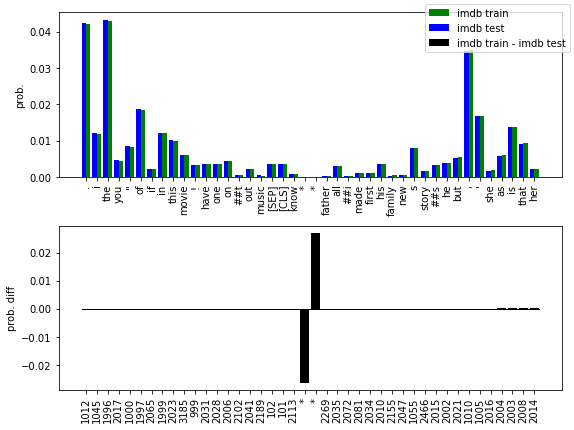

In [23]:
def plotdist(d1, d2, top, l1, l2):
    fig, ax = plt.subplots(2,1, figsize=(8,6))

    # ax[0].grid()
    ax[1].bar(x=range(len(top)), width=0.8, height=[t[2] for t in top], alpha=1.0, color="black", label=f"{l1} - {l2}")
    ax[0].bar(x=np.arange(len(top)) + 0.2, width=0.4, height=[d1[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="green", label=l1)    
    ax[0].bar(x=np.arange(len(top)) - 0.2, width=0.4, height=[d2[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="blue", label=l2)
    ax[0].set_xticks(ticks=range(len(top)), labels=[t[3] for t in top], rotation=90)
    ax[1].set_xticks(ticks=range(len(top)), labels=[str(t[0]) if t[0]>=0 else "*" for t in top], rotation=90)

    #ax[0].grid()
    #ax[1].grid()

    ax[1].plot([0,len(top) - 0.6], [0,0], lw=1, color='black')

    ax[0].set_ylabel("prob.")
    ax[1].set_ylabel("prob. diff")

    fig.legend()
    fig.tight_layout()

plotdist(d1=d1, d2=d2, top=top, l1='imdb train', l2='imdb test')

In [24]:
# toks = torch.tensor(toks_of_texts(imdb_train['text'])).to("cpu")
#task.model.roberta.embeddings.word_embeddings(toks)

In [25]:
# embs = task.model.roberta.embeddings.word_embeddings.to("cpu")(toks.to("cpu"))

In [26]:
# embs = embs.detach().numpy()

In [27]:
# plt.hist2d(embs[:,0], embs[:,1])